# Прогнозирование температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## План работы

1) Загрузить данные, ознакомиться со структурой таблиц, оценить количество пропусков и дубликатов.

2) Провести исследовательский анализ: изучить распределения признаков.

3) Провести предобработку: очистить данные от аномалий, заполнить пропуски и объединить таблицы. Добиться структуры "1 ключ - 1 строка". 

4) Подготовить данные к машинному обучению: разбить на обучающую и тестовую выборки, отделить целевой признак от остальных, провести масштабирование признаков для линейных моделей. 

5) Обучить разные регрессионные модели, подобрать гиперпараметры на кросс-валидации. В качестве метрики будем использовать MAE.

6) Протестировать наиболее успешную модель на тестовой выборке.

7) Составить отчет о выполненной работе.

## Загрузка и первичная оценка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.svm import SVR


#давим варнинги
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

random_state = 250722

In [2]:
try:
    data_arc = pd.read_csv(
        "C:\\Users\\Дмитрий\\Desktop\\DS Final Project\\final_steel\\data_arc.csv", 
        parse_dates=[1,2])
    data_bulk = pd.read_csv(
        "C:\\Users\\Дмитрий\\Desktop\\DS Final Project\\final_steel\\data_bulk.csv")
    data_bulk_time = pd.read_csv(
        "C:\\Users\\Дмитрий\\Desktop\\DS Final Project\\final_steel\\data_bulk_time.csv", 
        parse_dates = list(range(1,16,1)))
    data_gas = pd.read_csv(
        "C:\\Users\\Дмитрий\\Desktop\\DS Final Project\\final_steel\\data_gas.csv")
    data_temp = pd.read_csv(
        "C:\\Users\\Дмитрий\\Desktop\\DS Final Project\\final_steel\\data_temp.csv",
        parse_dates=[1])
    data_wire = pd.read_csv(
        "C:\\Users\\Дмитрий\\Desktop\\DS Final Project\\final_steel\\data_wire.csv")
    data_wire_time = pd.read_csv(
        "C:\\Users\\Дмитрий\\Desktop\\DS Final Project\\final_steel\\data_wire_time.csv",
        parse_dates = list(range(1,10,1)))

except:
    data_arc = pd.read_csv(
        "/datasets/final_steel/data_arc.csv", 
        parse_dates=[1,2])
    data_bulk = pd.read_csv(
        "/datasets/final_steel/data_bulk.csv")
    data_bulk_time = pd.read_csv(
        "/datasets/final_steel/data_bulk_time.csv", 
        parse_dates = list(range(1,16,1)))
    data_gas = pd.read_csv(
        "/datasets/final_steel/data_gas.csv")
    data_temp = pd.read_csv(
        "/datasets/final_steel/data_temp.csv",
        parse_dates=[1])
    data_wire = pd.read_csv(
        "/datasets/final_steel/data_wire.csv")
    data_wire_time = pd.read_csv(
        "/datasets/final_steel/data_wire_time.csv",
        parse_dates = list(range(1,10,1)))

In [3]:
def info(data):
    display(data)
    data.info()
    print('')
    print('Доля пропусков в колонках:')
    display(data.isna().sum()/len(data))
    print('Количество дубликатов:', data_bulk.duplicated().sum())

In [4]:
info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB

Доля пропусков в колонках:


key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64

Количество дубликатов: 0


В таблице `data_arc` представлены данные об этапах подогрева расплавленного металла с помощью электрода (начало и конец подогрева, активная и реактивная мощность электрода).

In [5]:
info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Доля пропусков в колонках:


key        0.000000
Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64

Количество дубликатов: 0


In [6]:
data_bulk['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

Основная часть таблицы `data_bulk` состоит из пропусков. Вероятно, каждый столбец обозначает добавление определенного сыпучего материала. Если материал не добавляли, значит в ячейке стоит пропуск. В будущем пропуски можно заменить на 0. Ключи в таблице не повторяются, значит добавление сыпучих материалов осуществляли в 1 заход.

In [7]:
info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaT,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:46:52,NaT,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaT,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:33:09,NaT,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:39:41,NaT,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 02:41:27,2019-09-01 02:41:27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB

Доля пропусков в колон

key        0.000000
Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64

Количество дубликатов: 0


В таблице `data_bulk_time` представлены значения времени, когда вносили реагент. Заполненные значения и пропуски совпадают с таблицей `data_bulk`. 

In [8]:
info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Доля пропусков в колонках:


key      0.0
Газ 1    0.0
dtype: float64

Количество дубликатов: 0


В `data_gas` содержатся данные по количеству газа, которое использовали для каждой партии.

In [9]:
info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB

Доля пропусков в колонках:


key             0.000000
Время замера    0.000000
Температура     0.182373
dtype: float64

Количество дубликатов: 0


Из `data_temp` видно, что температуру измеряли по нескольку раз для каждой партии. В значениях температуры присутствуют пропуски.

In [10]:
info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Доля пропусков в колонках:


key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64

Количество дубликатов: 0


In [11]:
info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-08-31 23:38:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-01 01:50:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-01 03:12:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB

Доля пропусков в колонках:


key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64

Количество дубликатов: 0


Таблица `data_wire` и `data_wire_time` имеют структуру, схожую с `data_bulk` и `data_bulk_time` (большая часть значений - пропуски). Вероятно, в этих таблицах указано количество и время добавки проволочных материалов (каждый материал в своей колонке).

## Исследовательский анализ

### data_arc

In [12]:
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

In [13]:
print('Начало нагрева дугой')
print('Первая запись:', data_arc['Начало нагрева дугой'].min())
print('Последняя запись:', data_arc['Начало нагрева дугой'].max())
print('')
print('Конец нагрева дугой')
print('Первая запись:', data_arc['Конец нагрева дугой'].min())
print('Последняя запись:', data_arc['Конец нагрева дугой'].max())

Начало нагрева дугой
Первая запись: 2019-05-03 11:02:14
Последняя запись: 2019-09-01 04:34:47

Конец нагрева дугой
Первая запись: 2019-05-03 11:06:02
Последняя запись: 2019-09-01 04:36:08


In [14]:
data_arc[['Активная мощность', 'Реактивная мощность']].describe()

,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000
mean,0.670441,0.452592
std,0.408159,5.878702
min,0.030002,-715.504924
25%,0.395297,0.290991
50%,0.555517,0.415962
75%,0.857034,0.637371
max,3.731596,2.676388


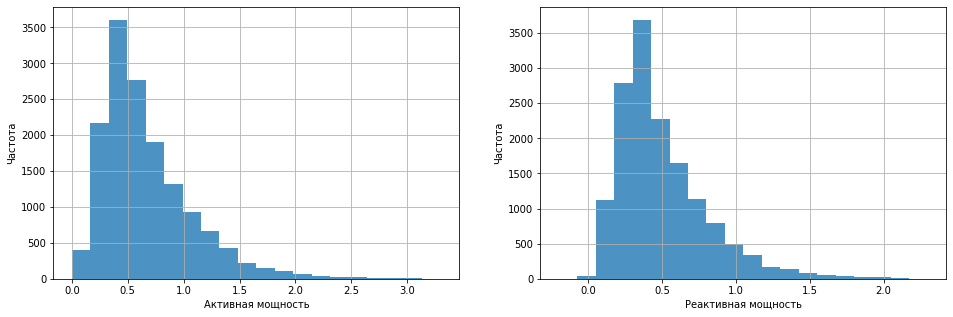

In [15]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.hist(data_arc['Активная мощность'], bins=20, range=(0, 3.3), alpha=0.8)
plt.xlabel('Активная мощность')
plt.ylabel('Частота')
plt.grid(True)

plt.subplot(122)
plt.hist(data_arc['Реактивная мощность'],range=(-0.2, 2.3), bins=20, alpha=0.8)
plt.xlabel('Реактивная мощность')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

* Большинство ключей встречаются больше 1 раза (партии нагревали по нескольку раз).

* В `data_arc` записи датируются с 2019-05-03 по 2019-09-01.

* Значения активной мощности варьируются от 0.03 до 3.73 со средним 0.67 и медианой 0.56. Распределение имеет длинный правый хвост. 

* Реактивная мощность варьируется от -715.50 до 2.68 со средним 0.45 и медианой 0.42. Форма распределения идентична активной мощности. Исходя из распределения, значения ниже 0 нереалистичны, поэтому отфильтруем данные.

### data_bulk и data_bulk_time

In [16]:
data_bulk['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

In [17]:
data_bulk.loc[:,'Bulk 1':].describe()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


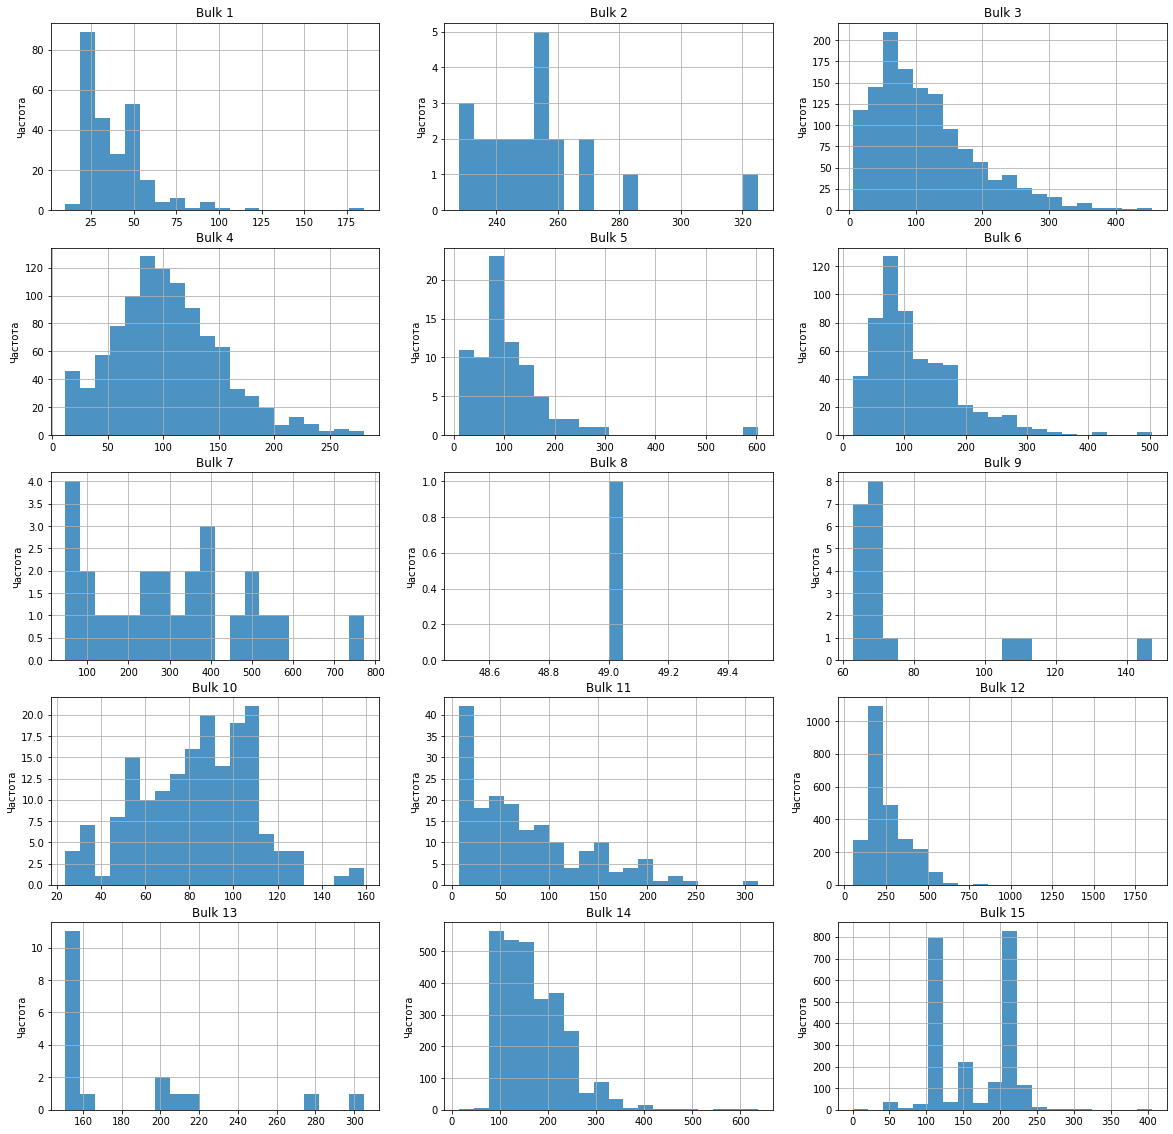

In [18]:
plt.figure(figsize=(20,20))
for i in range(1,16):
    column = f'Bulk {i}'
    plt.subplot(5, 3, i)
    plt.hist(data_bulk[column], alpha=0.8, bins=20)
    plt.title(column)
    plt.ylabel('Частота')
    plt.grid(True)

In [19]:
data_bulk_time.min()

key                          1
Bulk 1     2019-05-03 17:50:19
Bulk 2     2019-05-07 08:36:19
Bulk 3     2019-05-03 20:13:36
Bulk 4     2019-05-03 11:21:30
Bulk 5     2019-05-07 08:36:19
Bulk 6     2019-05-03 18:52:57
Bulk 7     2019-05-07 11:37:42
Bulk 8     2019-07-05 17:46:11
Bulk 9     2019-05-14 00:04:56
Bulk 10    2019-05-06 01:36:24
Bulk 11    2019-05-05 16:45:05
Bulk 12    2019-05-03 11:03:52
Bulk 13    2019-05-05 00:39:35
Bulk 14    2019-05-03 11:03:52
Bulk 15    2019-05-03 11:03:52
dtype: object

In [20]:
data_bulk_time.max()

key                       3241
Bulk 1     2019-08-30 23:01:32
Bulk 2     2019-08-08 17:34:38
Bulk 3     2019-08-31 23:39:11
Bulk 4     2019-08-30 17:36:30
Bulk 5     2019-08-28 09:01:08
Bulk 6     2019-09-01 03:12:40
Bulk 7     2019-08-31 07:22:25
Bulk 8     2019-07-05 17:46:11
Bulk 9     2019-08-11 15:09:33
Bulk 10    2019-08-30 01:30:42
Bulk 11    2019-08-31 16:00:49
Bulk 12    2019-09-01 01:39:41
Bulk 13    2019-08-26 20:31:16
Bulk 14    2019-09-01 04:05:34
Bulk 15    2019-09-01 04:05:34
dtype: object

* Ключи не повторяются, значит загрузку сыпучих материалов осуществляли однократно в каждой партии.
* В таблице `data_bulk` колонки имеют распределения неправильной формы (скорее всего, из-за недостатка данных). Чаще всего встречается распределение с длинными правым хвостом и скошенное слева, но также есть вариант, близкий к плато (`'Bulk 7'`), с двумя пиками (`'Bulk 15'`), с длинным левым хвостом (`'Bulk 10'`). 
* В стобце `'Bulk 8'` присутствует только 1 значение. Он не даст модели ценной информации, поэтому его можно удалить на этапе предобработки.
* Данные собраны за период с 03-05-2019 по 01-09-2019.

### data_gas

In [21]:
data_gas['key'].value_counts()

2049    1
3135    1
3115    1
1070    1
3119    1
       ..
2596    1
549     1
2600    1
553     1
2047    1
Name: key, Length: 3239, dtype: int64

In [22]:
data_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

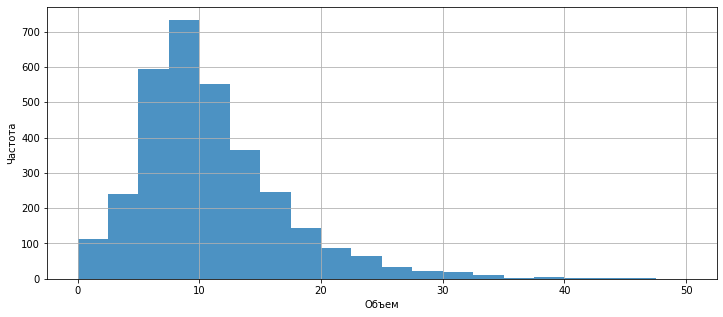

In [23]:
plt.figure(figsize=(12,5))
plt.hist(data_gas['Газ 1'], alpha=0.8, bins=20, range=(0,50))
plt.xlabel('Объем')
plt.ylabel('Частота')
plt.grid(True)

* В `data_gas` значения `'key'` не повторяются, значит продувку газом в каждой партии осуществляли однократно.
* Значения в поле `'Газ 1'` варьируются от 0.01 до 78.00 со средним 11 и медианой 9.84. Значения выше 40 встречаются крайне редко. Но т.к. это рельные данные с производственного процесса, отфильтровывать от выбросов не будем.

### data_temp

In [24]:
data_temp['key'].value_counts()

46      16
1214    16
1513    16
44      16
1689    15
        ..
1415     2
1836     2
2456     2
195      1
279      1
Name: key, Length: 3216, dtype: int64

In [25]:
print('Первая запись:', data_temp['Время замера'].min())
print('Последняя запись:', data_temp['Время замера'].max())

Первая запись: 2019-05-03 11:16:18
Последняя запись: 2019-09-01 04:38:08


In [26]:
data_temp['Температура'].describe()

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

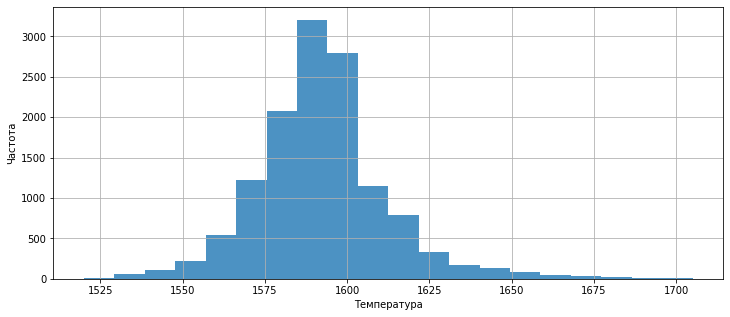

In [27]:
plt.figure(figsize=(12,5))
plt.hist(data_temp['Температура'], alpha=0.8, bins=20, range=(1520,1705))
plt.xlabel('Температура')
plt.ylabel('Частота')
plt.grid(True)

* Значения `'key'` встречаются по нескольку раз (за исключением партий 195 и 279), значит замеры температуры проводили несколько раз для каждой партии.
* Данные представлены за тот же промежуток времени, что и в предыдущих таблицах.
* Значения температуры варьируются от 1191 до 1705 со средним и медианой 1591. Значения ниже 1500 похожи на выбросы, возможно, стоит их удалить по согласованию с заказчиком.

### data_wire и data_wire_time

In [28]:
data_wire['key'].value_counts()

2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

In [29]:
data_wire.loc[:,'Wire 1':].describe()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


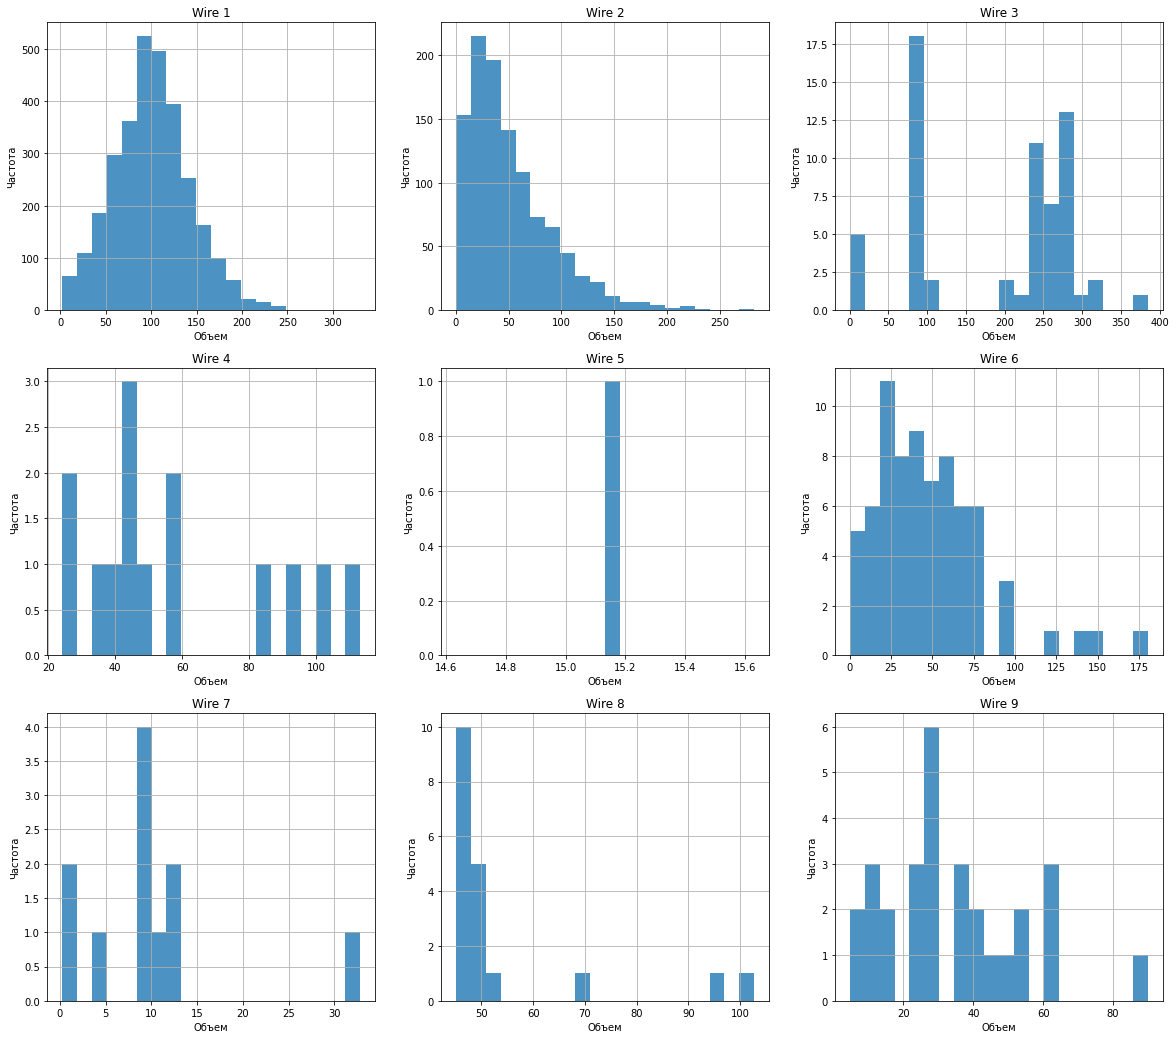

In [30]:
plt.figure(figsize=(20,18))
for i in range(1,10):
    column = f'Wire {i}'
    number = pd.to_numeric(f'33{i}').astype('int')
    plt.subplot(number)
    plt.hist(data_wire[column], alpha=0.8, bins=20)
    plt.title(column)
    plt.ylabel('Частота')
    plt.xlabel('Объем')
    plt.grid(True)    

In [31]:
data_wire_time.min()

key                         1
Wire 1    2019-05-03 11:11:41
Wire 2    2019-05-03 13:32:06
Wire 3    2019-05-04 04:47:53
Wire 4    2019-05-07 08:48:23
Wire 5    2019-08-08 16:01:07
Wire 6    2019-05-07 08:37:20
Wire 7    2019-07-23 12:08:44
Wire 8    2019-05-14 00:03:32
Wire 9    2019-05-04 16:09:11
dtype: object

In [32]:
data_wire_time.max()

key                      3241
Wire 1    2019-09-01 04:16:01
Wire 2    2019-08-31 18:50:15
Wire 3    2019-08-28 02:11:18
Wire 4    2019-08-08 12:03:12
Wire 5    2019-08-08 16:01:07
Wire 6    2019-08-14 00:59:11
Wire 7    2019-08-08 18:27:34
Wire 8    2019-08-11 15:09:29
Wire 9    2019-08-29 03:51:31
dtype: object

* Ключи не повторяются, значит загрузку проволочных материалов осуществляли однократно в каждой партии.
* В таблице `data_wire` встречаются следующие виды распределений: близкое к нормальному (`'Wire 1'`), с длинным правым хвостом и скошенное слева (`'Wire 2'`), с несколькими пиками (`'Wire 3'`). Практически все распределения имеют изолированные участки, что говорит о небольшом количестве наблюдений.
* В стобце `'Wire 5'` присутствует только 1 значение. Этот столбец будет неинформативен для модели, поэтому его можно удалить. 
* Данные представлены за тот же временной промежуток, что и в остальных таблицах.

**Какая нужна предобработка:**
1. Пропуски в таблицах `data_bulk` и `data_wire` заполнить 0 (пропуск означает, что реагент не добавляли).
2. Удалить столбцы `'Wire 5'` в `data_wire` и `'Bulk 8'` в `data_bulk`.
3. Таблицу `data_arc` сгруппировать по ключам, в качестве агрегирующей функции попробуем `sum`. Строки со отрицательным значением реактивной мощности удалим. 
4. Таблицу `data_temp` отсортируем по дате и времени, удалим ключи только с 1 измерением температуры, выделим первое и последнее измерения и вынесем в отдельный признак, все остальные измерения удалим. Оставим по одной строке на каждый ключ. 
5. Объединим подготовленные таблицы по `'key'` (`data_bulk_time` и `data_wire_time` в дальнейшей работе использовать не будем).

## Предобработка данных

Заполняем пропуски и удаляем неинформатиные столбцы в `data_bulk` и `data_wire`.

In [33]:
data_bulk = data_bulk.drop('Bulk 8', axis=1).fillna(0)
display(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [34]:
data_wire = data_wire.drop('Wire 5', axis=1).fillna(0)
display(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


Фильтруем таблицу `data_arc`

In [35]:
print('Первоначальная форма:', data_arc.shape)
data_arc = data_arc.loc[data_arc['Реактивная мощность'] >= 0]
print('Новая форма:', data_arc.shape)

Первоначальная форма: (14876, 5)
Новая форма: (14875, 5)


Добавим дополнительный признак: полную мощность (корень из суммы квадратов активной и реактивной мощностей).

In [36]:
data_arc['Полная мощность'] = ((data_arc['Активная мощность'])**2 + (data_arc['Реактивная мощность'])**2)**0.5
display(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489


Группируем `data_arc` по ключам, значения мощностей суммируем. В качестве дополнительного признака считаем этапы нагрева в каждой партии. 

In [37]:
data_arc = pd.pivot_table(data_arc, 
                          index='key', 
                          values=['Активная мощность', 
                                  'Реактивная мощность', 
                                  'Полная мощность'], 
                          aggfunc= ['sum', 'count'])
data_arc.columns = ['Активная мощность', 
                    'Полная мощность',
                    'Реактивная мощность', 
                    'Стадии нагрева',
                    'a', 'b' ]
data_arc = data_arc.drop(['a', 'b'], axis=1)

display(data_arc)

,Активная мощность,Полная мощность,Реактивная мощность,Стадии нагрева
key,,,,
1,4.878147,5.826395,3.183241,5
2,3.052598,3.649216,1.998112,4
3,2.525882,2.989534,1.599076,5
4,3.209250,3.814962,2.060298,4
5,3.347173,4.035758,2.252643,4
...,...,...,...,...
3237,3.932467,4.844982,2.828459,5
3238,2.106529,2.696542,1.681182,3
3239,4.666754,5.611883,3.111617,8


In [38]:
display(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Сортируем строки в `data_temp` по времени замера на случай немонотонности данных.

In [39]:
data_temp = data_temp.sort_values(by='Время замера')
display(data_temp.head(10))

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [40]:
data_temp.isna().sum()

key                0
Время замера       0
Температура     2901
dtype: int64

При группировке таблицы по ключам нам нужно вынести в отдельные столбцы первое и последнее измерение температуры. Но функции `first` и `last` не работают со значениями `NaN`, вместо пустого значения они будут выводить следующее(`first`) и предыдущее(`last`). Это исказит данные. Поэтому заполним пропуски нулем, сгруппируем таблицу `data_temp` по ключам, выведем в отдельные столбцы первое и последнее измерение, а также общее количество измерений. Если проводили всего 1 измерение, удалим соответствующий ключ. Также удалим ключи, где первое значение меньше 1500 (очищаем от выбросов по желанию заказчика), и последнее равно 0 (где раньше был пропуск).

In [41]:
data_temp = data_temp.fillna(0)

In [42]:
data_temp.isna().sum()

key             0
Время замера    0
Температура     0
dtype: int64

In [43]:
data_temp_pivot = data_temp.pivot_table(index='key', values='Температура', aggfunc=['first', 'last', 'count'])
data_temp_pivot.columns = ['Первое измерение', 'Последнее измерение', 'Количество измерений']
display(data_temp_pivot)

,Первое измерение,Последнее измерение,Количество измерений
key,,,
1,1571.0,1613.0,5
2,1581.0,1602.0,6
3,1596.0,1599.0,5
4,1601.0,1625.0,3
5,1576.0,1602.0,2
...,...,...,...
3237,1569.0,0.0,5
3238,1584.0,0.0,3
3239,1598.0,0.0,8


In [44]:
data_temp_pivot.shape

(3216, 3)

In [45]:
data_temp_pivot = data_temp_pivot.loc[(data_temp_pivot['Первое измерение'] >= 1500) & 
                                      (data_temp_pivot['Последнее измерение'] > 0)&
                                      (data_temp_pivot['Количество измерений'] > 1)]
data_temp_pivot.shape

(2471, 3)

Столбец `'Количество измерений'` выполнил свою функцию и больше не нужен, удаляем его.

In [46]:
data_temp_pivot = data_temp_pivot.drop('Количество измерений', axis=1)

Объединяем таблицы по ключу

In [47]:
data_bulk = data_bulk.set_index('key')
data_wire = data_wire.set_index('key')
data_gas = data_gas.set_index('key')

In [48]:
data = data_temp_pivot.join(data_arc, on='key', how='inner')
data = data.join(data_bulk, on='key', how='inner')
data = data.join(data_wire, on='key', how='inner')
data = data.join(data_gas, on='key', how='inner')

Создаем дополнительные признаки: общий объем сыпучих материалов и общий объем проволочных материалов для каждой партии.

In [49]:
data['bulk_sum'] = data.loc[:, 'Bulk 1':'Bulk 15'].sum(axis=1)
data['wire_sum'] = data.loc[:, 'Wire 1':'Wire 9'].sum(axis=1)

In [50]:
display(data)

,Первое измерение,Последнее измерение,Активная мощность,Полная мощность,Реактивная мощность,Стадии нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,bulk_sum,wire_sum
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,4.878147,5.826395,3.183241,5,0.0,0.0,0.0,43.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,553.0,60.059998
2,1581.0,1602.0,3.052598,3.649216,1.998112,4,0.0,0.0,0.0,73.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,582.0,96.052315
3,1596.0,1599.0,2.525882,2.989534,1.599076,5,0.0,0.0,0.0,34.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,544.0,91.160157
4,1601.0,1625.0,3.209250,3.814962,2.060298,4,0.0,0.0,0.0,81.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,595.0,89.063515
5,1576.0,1602.0,3.347173,4.035758,2.252643,4,0.0,0.0,0.0,78.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,584.0,98.352796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,3.210690,3.986869,2.360777,4,0.0,0.0,21.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,7.125735,719.0,89.150879
2496,1554.0,1591.0,4.203064,5.057033,2.810185,6,0.0,0.0,0.0,63.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,9.412616,796.0,114.179527
2497,1571.0,1589.0,2.212379,2.885017,1.851269,3,0.0,0.0,0.0,85.0,...,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,6.271699,665.0,103.134723


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2499
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Первое измерение     2325 non-null   float64
 1   Последнее измерение  2325 non-null   float64
 2   Активная мощность    2325 non-null   float64
 3   Полная мощность      2325 non-null   float64
 4   Реактивная мощность  2325 non-null   float64
 5   Стадии нагрева       2325 non-null   int64  
 6   Bulk 1               2325 non-null   float64
 7   Bulk 2               2325 non-null   float64
 8   Bulk 3               2325 non-null   float64
 9   Bulk 4               2325 non-null   float64
 10  Bulk 5               2325 non-null   float64
 11  Bulk 6               2325 non-null   float64
 12  Bulk 7               2325 non-null   float64
 13  Bulk 9               2325 non-null   float64
 14  Bulk 10              2325 non-null   float64
 15  Bulk 11              2325 non-null   f

## Подготовка к машинному обучению

Выделяем целевой признак и остальные признаки

In [52]:
features = data.drop('Последнее измерение', axis=1)
target = data['Последнее измерение']
display(features.head())
display(target.head())

,Первое измерение,Активная мощность,Полная мощность,Реактивная мощность,Стадии нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,bulk_sum,wire_sum
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,4.878147,5.826395,3.183241,5,0.0,0.0,0.0,43.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,553.0,60.059998
2,1581.0,3.052598,3.649216,1.998112,4,0.0,0.0,0.0,73.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,582.0,96.052315
3,1596.0,2.525882,2.989534,1.599076,5,0.0,0.0,0.0,34.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,544.0,91.160157
4,1601.0,3.209250,3.814962,2.060298,4,0.0,0.0,0.0,81.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,595.0,89.063515
5,1576.0,3.347173,4.035758,2.252643,4,0.0,0.0,0.0,78.0,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,584.0,98.352796


key
1    1613.0
2    1602.0
3    1599.0
4    1625.0
5    1602.0
Name: Последнее измерение, dtype: float64

Разделяем на обучающую и тестовую выборки

In [53]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=random_state)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(1743, 30)
(582, 30)
(1743,)
(582,)


Создаем масштабированные выборки для линейных моделей.

In [54]:
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)
display(features_train_scaled)
display(features_test_scaled)

array([[ 0.45487595, -0.9256297 , -0.79383477, ..., -0.36878414,
        -0.47388689, -0.55828703],
       [ 0.32776253, -1.08000482, -1.1400051 , ..., -0.7384085 ,
        -1.48497751,  0.08288813],
       [ 0.15827797, -0.02378815, -0.01227909, ..., -0.54582658,
         1.1466282 , -0.50814797],
       ...,
       [ 0.79384507, -0.15070885, -0.15032551, ..., -0.53779954,
        -0.71280899, -1.36580518],
       [ 1.55652559, -0.48395769, -0.55572058, ..., -0.11563978,
         0.06628481,  1.17266207],
       [ 1.38704103, -1.63010451, -1.6464352 , ..., -1.40841138,
        -2.0251492 , -0.95431459]])

array([[-0.434918  ,  1.1209351 ,  1.14490885, ..., -1.09855629,
         1.51713058, -0.27234986],
       [ 1.21755647, -0.72507189, -0.76367182, ..., -0.58181066,
         0.07321008, -0.11438072],
       [-0.39254686,  2.31716943,  2.56040118, ..., -0.45135629,
        -0.29036702, -1.13221619],
       ...,
       [ 1.51415445,  2.16482142,  2.24065361, ...,  2.22774746,
         2.07115284,  0.18306392],
       [-0.434918  ,  0.252107  ,  0.19973072, ...,  1.26169837,
        -0.62970565, -1.11921909],
       [ 1.93786585, -1.55780726, -1.54430814, ..., -0.99046841,
        -2.05977559, -0.64222899]])

Настраиваем кросс-валидацию

In [55]:
folds = StratifiedKFold(n_splits=5,  shuffle=True, random_state=random_state)   

Создаем словарь для записи результатов моделирования

In [56]:
results = {'training_time': [],
           'pred_time': [],
           'cv_mae': []
          }

Создаем функцию для автоматизации моделирования и записи результатов

In [57]:
def modelling(model, features_train, target_train, cv_res):
    start_train = time.time()
    model.fit(features_train, target_train)
    stop_train = time.time()
    pred = model.predict(features_train)
    stop_pred = time.time()
    results.setdefault('training_time',[]).append('{0:.3f}'.format(stop_train-start_train))
    results.setdefault('pred_time',[]).append('{0:.3f}'.format(stop_pred-stop_train))
    results.setdefault('cv_mae',[]).append('{0:.6f}'.format(abs(cv_res.mean())))
    display(results)

## Машинное обучение

### Линейная регрессия

In [58]:
model_lr = LinearRegression()
cv_lr = cross_val_score(estimator=model_lr, 
                      X=features_train_scaled,
                      y=target_train, 
                      scoring='neg_mean_absolute_error',
                      cv=folds, 
                      n_jobs=-1)

D:\Programmes\Anaconda\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [59]:
modelling(model_lr, features_train_scaled, target_train, cv_lr)

{'training_time': ['0.006'], 'pred_time': ['0.001'], 'cv_mae': ['6.144827']}

### Lasso

In [60]:
model_lasso = Lasso(random_state = random_state)
parameters = {'alpha': [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2]}
grid_lasso = GridSearchCV(model_lasso, param_grid=parameters, scoring='neg_mean_absolute_error', n_jobs=-1, cv=folds)
grid_lasso.fit(features_train_scaled, target_train)
cv_lasso= grid_lasso.best_score_
print(grid_lasso.best_params_)

D:\Programmes\Anaconda\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'alpha': 0.1}


In [61]:
modelling(grid_lasso.best_estimator_, features_train_scaled, target_train, cv_lasso)

{'training_time': ['0.006', '0.000'],
 'pred_time': ['0.001', '0.000'],
 'cv_mae': ['6.144827', '6.062629']}

### Ridge

In [62]:
model_ridge = Ridge(random_state = random_state)
parameters = {'alpha': [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2]}
grid_ridge = GridSearchCV(model_ridge, param_grid=parameters, scoring='neg_mean_absolute_error', n_jobs=-1, cv=folds)
grid_ridge.fit(features_train_scaled, target_train)
cv_ridge= grid_ridge.best_score_
print(grid_ridge.best_params_)

{'alpha': 2}


D:\Programmes\Anaconda\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [63]:
modelling(grid_ridge.best_estimator_, features_train_scaled, target_train, cv_ridge)

{'training_time': ['0.006', '0.000', '0.002'],
 'pred_time': ['0.001', '0.000', '0.000'],
 'cv_mae': ['6.144827', '6.062629', '6.134607']}

### ElasticNet

In [64]:
model_elastic = ElasticNet(random_state = random_state)
parameters = {'alpha': [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2],
              'l1_ratio': np.arange(0.1, 1, 0.1)}
grid_elastic = GridSearchCV(model_elastic, param_grid=parameters, scoring='neg_mean_absolute_error', n_jobs=-1, cv=folds)
grid_elastic.fit(features_train_scaled, target_train)
cv_elastic= grid_elastic.best_score_
print(grid_elastic.best_params_)

D:\Programmes\Anaconda\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'alpha': 0.05, 'l1_ratio': 0.9}


In [65]:
modelling(grid_elastic.best_estimator_, features_train_scaled, target_train, cv_elastic)

{'training_time': ['0.006', '0.000', '0.002', '0.005'],
 'pred_time': ['0.001', '0.000', '0.000', '0.001'],
 'cv_mae': ['6.144827', '6.062629', '6.134607', '6.079281']}

### Метод опорных векторов

In [66]:
model_svm = SVR()
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2]}
grid_svm = GridSearchCV(model_svm, param_grid=parameters, scoring='neg_mean_absolute_error', n_jobs=-1, cv=folds)
grid_svm.fit(features_train_scaled, target_train)
cv_svm= grid_svm.best_score_
print(grid_svm.best_params_)

D:\Programmes\Anaconda\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 1, 'kernel': 'linear'}


In [67]:
modelling(grid_svm.best_estimator_, features_train_scaled, target_train, cv_svm)

{'training_time': ['0.006', '0.000', '0.002', '0.005', '0.222'],
 'pred_time': ['0.001', '0.000', '0.000', '0.001', '0.092'],
 'cv_mae': ['6.144827', '6.062629', '6.134607', '6.079281', '6.097648']}

### Дерево решений

In [68]:
model_dt = DecisionTreeRegressor(random_state=random_state)
parameters = {'max_depth': range(3,26,1)}
grid_dt = GridSearchCV(model_dt, param_grid=parameters, scoring='neg_mean_absolute_error', n_jobs=-1, cv=folds)
grid_dt.fit(features_train, target_train)
cv_dt= grid_dt.best_score_
print(grid_dt.best_params_)

D:\Programmes\Anaconda\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'max_depth': 5}


In [69]:
modelling(grid_dt.best_estimator_, features_train, target_train, cv_dt)

{'training_time': ['0.006', '0.000', '0.002', '0.005', '0.222', '0.015'],
 'pred_time': ['0.001', '0.000', '0.000', '0.001', '0.092', '0.003'],
 'cv_mae': ['6.144827',
  '6.062629',
  '6.134607',
  '6.079281',
  '6.097648',
  '6.939768']}

### Случайный лес

In [70]:
%%time

model_rf = RandomForestRegressor(random_state=random_state)
parameters = {'max_depth': range(3,26,1), 'n_estimators' : [10, 20, 40, 60, 100, 200, 300, 500, 1000, 1500, 2000]}
grid_rf = GridSearchCV(model_rf, param_grid=parameters, scoring='neg_mean_absolute_error', n_jobs=-1, cv=folds)
grid_rf.fit(features_train, target_train)
cv_rf= grid_rf.best_score_
print(grid_rf.best_params_)

D:\Programmes\Anaconda\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'max_depth': 18, 'n_estimators': 1500}
CPU times: total: 24.1 s
Wall time: 20min 28s


In [71]:
modelling(grid_rf.best_estimator_, features_train, target_train, cv_rf)

{'training_time': ['0.006',
  '0.000',
  '0.002',
  '0.005',
  '0.222',
  '0.015',
  '18.918'],
 'pred_time': ['0.001', '0.000', '0.000', '0.001', '0.092', '0.003', '0.471'],
 'cv_mae': ['6.144827',
  '6.062629',
  '6.134607',
  '6.079281',
  '6.097648',
  '6.939768',
  '5.985414']}

### KNeighbors

In [72]:
%%time

model_kn = KNeighborsRegressor(n_jobs=-1)
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 10, 15],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
             }
grid_kn = GridSearchCV(model_kn, param_grid=parameters, cv=folds, scoring='neg_mean_absolute_error')

grid_kn.fit(features_train, target_train)
cv_kn = grid_kn.best_score_

print(grid_kn.best_params_)

D:\Programmes\Anaconda\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'algorithm': 'auto', 'n_neighbors': 15, 'weights': 'uniform'}
CPU times: total: 10.1 s
Wall time: 6.98 s


In [73]:
modelling(grid_kn.best_estimator_, features_train, target_train, cv_kn)

{'training_time': ['0.006',
  '0.000',
  '0.002',
  '0.005',
  '0.222',
  '0.015',
  '18.918',
  '0.001'],
 'pred_time': ['0.001',
  '0.000',
  '0.000',
  '0.001',
  '0.092',
  '0.003',
  '0.471',
  '0.107'],
 'cv_mae': ['6.144827',
  '6.062629',
  '6.134607',
  '6.079281',
  '6.097648',
  '6.939768',
  '5.985414',
  '7.548692']}

### Градиентный бустинг LGBM

In [74]:
%%time

model_lgbm = LGBMRegressor(n_jobs=-1, random_state=random_state)
parameters = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
              'max_depth': range(3,26,1),
              'n_estimators': [10, 20, 40, 60, 100, 200, 300, 500, 1000, 1500]
             }
grid_lgbm = GridSearchCV(model_lgbm, param_grid=parameters, cv=folds, scoring='neg_mean_absolute_error')

grid_lgbm.fit(features_train, target_train)
cv_lgbm = grid_lgbm.best_score_

print(grid_lgbm.best_params_)

D:\Programmes\Anaconda\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'learning_rate': 0.005, 'max_depth': 9, 'n_estimators': 1000}
CPU times: total: 4h 8min 25s
Wall time: 31min 15s


In [75]:
modelling(grid_lgbm.best_estimator_, features_train, target_train, cv_lgbm)

{'training_time': ['0.006',
  '0.000',
  '0.002',
  '0.005',
  '0.222',
  '0.015',
  '18.918',
  '0.001',
  '0.759'],
 'pred_time': ['0.001',
  '0.000',
  '0.000',
  '0.001',
  '0.092',
  '0.003',
  '0.471',
  '0.107',
  '0.031'],
 'cv_mae': ['6.144827',
  '6.062629',
  '6.134607',
  '6.079281',
  '6.097648',
  '6.939768',
  '5.985414',
  '7.548692',
  '5.827437']}

### Результаты моделей на кросс-валидации

In [76]:
#строим таблицу с результатами
columns = pd.Series(['Linear_Regression',
                     'Lasso', 
                     'Ridge',
                     'ElasticNet',
                     'SVM', 
                     'Decision_Tree', 
                     'Random_Forest', 
                     'KNeighbors', 
                     'LGBM_Regressor'])
table = pd.DataFrame.from_dict(results, 
                               orient='index', 
                               columns=columns)
display(table)

,Linear_Regression,Lasso,Ridge,ElasticNet,SVM,Decision_Tree,Random_Forest,KNeighbors,LGBM_Regressor
training_time,0.006,0.000,0.002,0.005,0.222,0.015,18.918,0.001,0.759
pred_time,0.001,0.000,0.000,0.001,0.092,0.003,0.471,0.107,0.031
cv_mae,6.144827,6.062629,6.134607,6.079281,6.097648,6.939768,5.985414,7.548692,5.827437


* Лучший результат MAE=5.83 показала модель градиентного бустинга LGBM (`'learning_rate': 0.05`, `'max_depth': 9`, `'n_estimators': 1000`). Также эта модель обладает достаточно высокой скоростью обучения и предсказания.

* Модель случайного леса с 1500 деревьев и глубиной 18 также показала высокую точность (MAE = 5.98). Однако данная модель на несколько порядков дольше обучается и предсказывает, по сравнению с остальными моделями.

* Модели линейной регрессии (в т.ч. Lasso, Ridge и Elastic) обладают самой высокой скоростью обучения и предсказания. Также они имеют относительно хорошую точность (MAE = 6.06 - 6.14).

* Остальные модели (SVM, Decision tree, KNeighbors) уступают предыдущим в точности и/или времени обучения и предсказания.

Наиболее подходящая модель `LGBM_Regressor` со следующими параметрами: `'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 1000`. Она показала самую высокую точность и достаточную скорость обучения и предсказания. Проверим ее на тестовой выборке.

### Тестирование модели

In [77]:
model = grid_lgbm.best_estimator_
model.fit(features_train, target_train)
predictions = model.predict(features_test)
result = mean_absolute_error(target_test, predictions)
display(result)

5.921567842319269

На тестовой выборке значение MAE составило 5.92. Модель показала высокую точность и не переобучилась.

## Отчет

Ключевыми стадиями проекта оказались исследовательский анализ, предобработка, подбор моделей и гиперпараметров. Без любого из этих этапов мы бы не достигли нужного значения метрики. При анализе данных выявили выбросы. На этапе предобработки очистили часть выбросов, создали новые признаки и преобразовали данные в подходящую для моделей форму. При моделировании только модель градиентного бустинга с подобранными гиперпараметрами достигла нужного качества предсказаний (MAE ≤ 6).

Выполнили все пункты плана, за исключением полной очистки данных от выбросов. Очистку от выбросов в столбцах с температурой и реактивной мощностью согласовали с заказчиком. Однако очистку от выбросов столбца с объемом инертного газа не согласовали, - несмотря на аномалии с точки зрения статистики, в реальных процессах такие значения допустимы.

В ходе исследования данных выяснили, что столбцы `'Wire 5'` и `'Bulk 8'` имеют по одному ненулевому значению и потому не подходят в качестве признаков, поэтому их удалили. 

Таблицы с временем добавления реагентов (`data_bulk_time` и `data_wire_time`) и другие столбцы с датами не использовали, т.к., по информации от заказчика, время записывалось неточно. Кроме того, в данном случае разумнее прогнозировать температуру исходя из физико-химических основ процесса: мощности нагрева, количества добавленных реагентов и начальной температуры сплава, а не на основе временного ряда.

Для улучшения качества модели внепланово создали дополнительные признаки: полную мощность (рассчитали по формуле из физики), количество этапов нагрева, суммарные объемы сыпучих материалов и проволоки. 

Наиболее проблематичным этапом была предобработка данных. Нужно было правильно сгруппировать данные из всех таблиц по номерам партий, при этом удалить номера с одним измерением температуры или пропусками в измерениях. Проблему решили путем заполнения пропусков фиктивными значениями и созданием фиктивных столбцов.

При обучении моделей использовали следующие признаки: первое измерение температуры, активную, реактивную и полную мощности, количество стадий нагрева, объемы добавленных сыпучих и проволочных материалов (за исключением `'Wire 5'` и `'Bulk 8'`), суммарные объемы сыпучих и проволочных материалов (`wire_sum`, `bulk_sum`).

При моделировании исследовали 9 регрессионных моделей. В качестве метрики использовали `MAE` благодаря ее простой интерпретации. Данные разделили в соотношении 3:1 на обучающую и тестовую выборки. Чтобы не тратить данные на валидационную выборку, использовали кросс-валидацию с разбиением на 5 частей. Гиперпараметры подбирали поиском по сетке (`GridSearchCV`).

Лучший результат на кросс-валидации (`MAE = 5.83`) получила модель градиентного бустинга `LGBM` со следующими гиперпараметрами: (`'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 1000`). При тестировании метрика незначительно выросла и составила MAE = 5.92. Модель соответствует максимальному требованию заказчика (MAE ≤ 6), при этом обладает достаточной скоростью обучения и предсказания.